# Is it a cat or a dog?

This notenbook uses the concepts presented in the "Is it a bird?"-notebook to implement a model which can differentiate is a picture shows a cat or a dog.

## Step 1: Downloading the images

### Step 1a: Understanding the download API

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [2]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

The above code contains a lot of magic, so let's unpack:

The first element is fairly simple, the search itself: `ddg_images` returns a list of images, and each image is represented by a dictionary:

In [3]:
ddg_images("cat", max_results=2)

[{'title': 'beautiful, Gray, Cat Wallpapers HD / Desktop and Mobile Backgrounds',
  'image': 'https://wallup.net/wp-content/uploads/2019/09/1667-beautiful-gray-cat.jpg',
  'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.8ciros7Aiwy1rwRBJTx8owHaEo&pid=Api',
  'url': 'https://wallup.net/beautiful-gray-cat/',
  'height': 1600,
  'width': 2560,
  'source': 'Bing'},
 {'title': 'Cat - Cats Wallpaper (40547181) - Fanpop',
  'image': 'http://images6.fanpop.com/image/photos/40500000/Cat-cats-40547181-1680-1050.jpg',
  'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.fs03VYi78kJokUkzUbxLbwHaEo&pid=Api',
  'url': 'http://www.fanpop.com/clubs/cats/images/40547181/title/cat-wallpaper',
  'height': 1050,
  'width': 1680,
  'source': 'Bing'}]

The `L`-class is implemented in `fastcore`, see the documenation here: <https://fastcore.fast.ai/foundation.html#l>. `L` is an enhanced list:

In [4]:
L(ddg_images("cat", max_results=2))

(#2) [{'title': 'beautiful, Gray, Cat Wallpapers HD / Desktop and Mobile Backgrounds', 'image': 'https://wallup.net/wp-content/uploads/2019/09/1667-beautiful-gray-cat.jpg', 'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.8ciros7Aiwy1rwRBJTx8owHaEo&pid=Api', 'url': 'https://wallup.net/beautiful-gray-cat/', 'height': 1600, 'width': 2560, 'source': 'Bing'},{'title': 'Cat - Cats Wallpaper (40547181) - Fanpop', 'image': 'http://images6.fanpop.com/image/photos/40500000/Cat-cats-40547181-1680-1050.jpg', 'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.fs03VYi78kJokUkzUbxLbwHaEo&pid=Api', 'url': 'http://www.fanpop.com/clubs/cats/images/40547181/title/cat-wallpaper', 'height': 1050, 'width': 1680, 'source': 'Bing'}]

The `itemgot`-[method](https://fastcore.fast.ai/foundation.html#l.itemgot) returns a new `L` which only contains the image urls.

In [5]:
L(ddg_images("cat", max_results=2)).itemgot('image')

(#2) ['https://wallup.net/wp-content/uploads/2019/09/1667-beautiful-gray-cat.jpg','http://images6.fanpop.com/image/photos/40500000/Cat-cats-40547181-1680-1050.jpg']

Therefore, the `search_images` function retuns a list of URLs of the images of the search result:

In [53]:
urls = search_images('cat picture', max_images=1)
urls[0]

Searching for 'cat picture'


'https://www.thesprucepets.com/thmb/80yJRtk5pUPr0SSQUQaIlf5xqTY=/5000x3338/filters:fill(auto,1)/GettyImages-1067347086-5c8a9c4246e0fb000172efc3.jpg'

### Step 1b: Download a cat picture and a dog picture

To display the image, let's download it:

In [55]:
# Introducing a new parameter to control if the download of the images should be done.
# If you want to download new images, simply set it to `True`
do_download = True

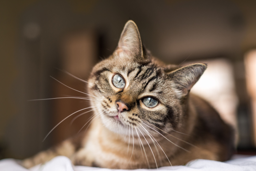

In [56]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'dog picture'


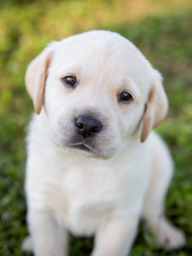

In [49]:
download_url(search_images('dog picture', max_images=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

Let's also download a dog picture, but with a more compact syntax:

### Step 1c: Download cats and dogs for the dataset

In [10]:
searches = 'cat','dog'
path = Path('.')
from time import sleep

In [32]:
if do_download:
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o}'))
        sleep(10)  # Pause between searches to avoid over-loading server
        download_images(dest, urls=search_images(f'{o} photo'))
        sleep(10)
        download_images(dest, urls=search_images(f'{o} picture'))
        sleep(10)
        resize_images(path/o, max_size=400, dest=path/o)

print("Done")

Searching for 'cat'
Searching for 'cat photo'
Searching for 'cat picture'
Searching for 'dog'
Searching for 'dog photo'
Searching for 'dog picture'
Done


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Step 2: Train the Model

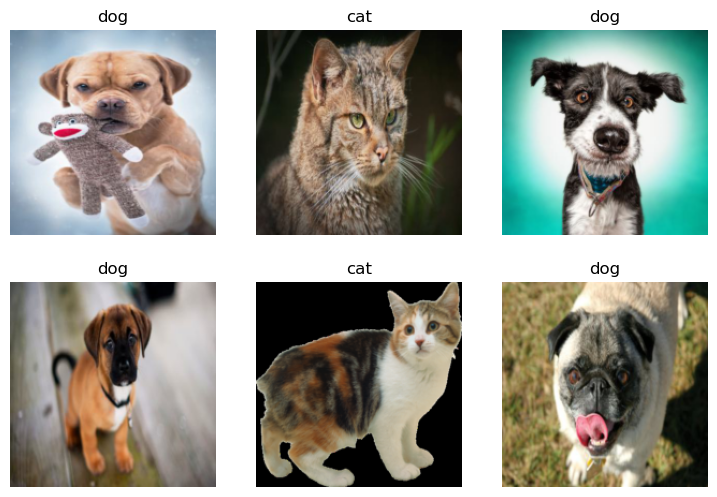

In [37]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [38]:
# when performing the next cell, I received a warning, that the resnet18 will need to be called differently in the future.
# to avoid the confusing message (it confused me a lot), I decided to simply supress the warning as suggested here:
# https://github.com/JaidedAI/EasyOCR/issues/766
# After all, it is just a warning ;)
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.107593,0.208187,0.056818,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.111101,0.207996,0.045455,00:41
1,0.083495,0.145115,0.045455,00:50
2,0.059912,0.146568,0.045455,00:44


Very nice, trained in about 2 minutes, and very nice results, especially for such a small dataset!

## Step 3: Test the model

### Step 3a: Test the cat picture

In [57]:
pred,pred_idx,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a {pred}.")

print(f"Probability it's other: {probs[0]:.4f}")
print(f"Probability it's a cat: {probs[1]:.4f}")
print(f"Probability it's a dog: {probs[2]:.4f}")

This is a cat.
Probability it's other: 0.0002
Probability it's a cat: 0.9998
Probability it's a dog: 0.0000


I created the above texts with a little bit of trial and error... How do I match the probalities to the predictions?

For a start, here is the raw result of the prediction:

In [58]:
learn.predict(PILImage.create('cat.jpg'))

('cat', TensorBase(1), TensorBase([1.5280e-04, 9.9985e-01, 1.6395e-12]))

The categories can be extracted from the so called vocab:

In [59]:
learn.dls.vocab

['', 'cat', 'dog']

In [60]:
learn.dls.vocab[pred_idx]

'cat'

### Step 3b: Test the dog picture

In [61]:
pred,pred_idx,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a {pred}.")

print(f"Probability it's other: {probs[0]:.4f}")
print(f"Probability it's a cat: {probs[1]:.4f}")
print(f"Probability it's a dog: {probs[2]:.4f}")

This is a dog.
Probability it's other: 0.0016
Probability it's a cat: 0.0000
Probability it's a dog: 0.9984
